In [0]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from pandas_ml import ConfusionMatrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer, f1_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from prettytable import PrettyTable
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
from sklearn.neighbors import NearestNeighbors
import plotly.plotly as py
from plotly.graph_objs import *
import plotly
plotly.tools.set_credentials_file(username'MyUsername', api_key='MyAPIkey')
import plotly.graph_objs as go

# Utility Functions

In [0]:
#We create a few utility functions whose use is described below
 

def plot_df_wordcloud(data,labels_list):
    #This function plots the wordcloud for DBScan. These will be called in the following functions.
    print('\n')
    print("Creating a dataframe with Reviews, Cleaned text and Clusters...")
    lst_reviews = list(data['Text'].values) #Saving all reviews into a list
    lst_cleanedtext = list(data['CleanedText'].values) #Saving all Cleaned text into a list
    amz = {'Reviews': lst_reviews,'CleanedText':lst_cleanedtext ,'Clusters': labels_list} #Creating a dictionary with Reviews, Cleaned text and clusters
    df = pd.DataFrame(amz, index=[labels_list], columns=['Reviews','CleanedText', 'Clusters']) #Creating a dataframe of the above dictionary
    print("Dataframe is created!")
    print('\n')
    
    print("The number of reviews in each cluster is:")
    print(df['Clusters'].value_counts()) #Outputs the number of reviews in each cluster
    print('\n')
    print('*'*70)
    
    for i in range(min(labels_list),max(labels_list)+1): #Iterates through K and prints wordcloud and reviews for all the clusters
        print('\n')
        print('\n')
        print("*"*40,'Cluster ',i,"*"*40)
        words=[] #Create an empty list to store words
        for sent in df['CleanedText'][df['Clusters']==i].values: #Splits sentences into words and stores it in a list
            words.append([a for a in sent.split()]) #Appends the split words to above created list
        
        word_list = [item for sublist in words for item in sublist] #Creates a new list of words by flattening the above list since it is a nested list
        print('\n')
        print('Plot of Word Cloud')
        wordcloud1 = WordCloud().generate(" ".join(word_list)) #Initiate wordcloud for the list of words
        plt.figure() #Plots the wordcloud
        plt.imshow(wordcloud1)
        plt.axis("off")
        plt.show()
    
        count = df['Reviews'][df['Clusters']==i].count()    
        if count//2>=9:#Prints random 5 reviews if the number of reviwes in that cluster is more than 100
            print('\n')
            print('\n')
            print('Printing 4 random reviews from cluster',i)
            pd.set_option('display.max_colwidth', -1) #Displays full reviews
            print(df['Reviews'][df['Clusters']==i][count//2:count//2+5])
            print('\n')
            print('\n')
        else: #Prints random reviews if the number of reviwes in that cluster is between 10 and 100
            print('\n')
            print('\n')
            print('Printing random reviews from cluster',i)
            pd.set_option('display.max_colwidth', -1) #Displays reviews in full length
            print(df['Reviews'][df['Clusters']==i][count//2:])
            print('\n')
            print('\n')
    
def plot_plotly(data,std_data,dist,ind): #This function plots the graph for indices vs distances using plotly. Plotly is chosen so that we can pin point the exact X and Y axis co-ordinates for Eps
    trace = go.Scatter(x = ind, y = dist) #Initialize trace with X as indices and Y as distances
    layout = go.Layout(title='Indicies vs Distance plot',xaxis=dict(title='Indicies'),yaxis=dict(title='Distances')) #Setting the title, x label and y label
    fig = go.Figure(data=[trace], layout=layout) 
    return py.iplot(fig, filename='basic-line') #Plots the graph
    
    
def dbscan(data,std_data,eps,min_pts): #Performs Dbscan on the Eps chosen form the above graph, min_pts is the number of min points chosen which is 2*d in this case where d is dimensionality
    clf = DBSCAN(eps=eps, min_samples=min_pts) #Initialize DBSCAN
    clf.fit(std_data)
    labels_list_check = clf.labels_.tolist() #Gets the labels and converts it into a list
    print('\n')
    df = pd.DataFrame({'labels':labels_list_check}) #Create a dataframe with labels list to see how many points are in each cluster
    print('For Eps =',eps,'the number of points in each cluster are:')
    print('\n')
    print(df['labels'].value_counts()) #Prints the number of points in each cluster for the given Eps value
    print('\n')
    print('\n')
    print('='*20,'Plotting wordcloud and reviews for Eps =',eps)
    print('\n')
    plot_df_wordcloud(data,labels_list_check) #Plot wordcloud and print a few random reviews
    

# Avg WordVec

In [0]:
import pandas as pd
final = pd.read_csv("drive/grouped_data_200.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(30000) #Gets 30000 reviews of positive and 20000 negative scores
neg_2000 = neg.sample(20000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores=grouped_data['Score']
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (49997, 12)


Observations:
A csv file is imported which consists of 200000 data points. These data points are already sorted on the basis of time. We create a new dataframe with over 50000 data points.

In [0]:
list_of_sent=[]
for sent in grouped_data['CleanedText'].values: #Splits sentences into words and stores it in a list
    list_of_sent.append(sent.split())
print(grouped_data['CleanedText'].values[9])
print("*****************************************************************")
print(list_of_sent[9])

tri mani jasmin blend found dragon pearl blend basic regular jasmin novelti leav roll tight littl dri unfurl infus far tell noth enchanc flavor brew nice jasmin blend noth would recommend jasmin lover
*****************************************************************
['tri', 'mani', 'jasmin', 'blend', 'found', 'dragon', 'pearl', 'blend', 'basic', 'regular', 'jasmin', 'novelti', 'leav', 'roll', 'tight', 'littl', 'dri', 'unfurl', 'infus', 'far', 'tell', 'noth', 'enchanc', 'flavor', 'brew', 'nice', 'jasmin', 'blend', 'noth', 'would', 'recommend', 'jasmin', 'lover']


Observations: Get a list of all the words in data.

In [0]:
w2v_train=Word2Vec(list_of_sent,min_count=5,size=200, workers=4) #Initialises the Word2Vec model with words occuring more than 5 times.

w2v_train_words = list(w2v_train.wv.vocab) #This gives a dictionary of words which tells about the uniqueness of a word among other things.
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[298:315])

number of words that occured minimum 5 times  9521
sample words  ['franci', 'chicken', 'liver', 'buy', 'pleas', 'amaz', 'flavor', 'chees', 'food', 'triangl', 'throughout', 'childhood', 'bold', 'volum', 'histori', 'age', 'virtual']


Observations: Train the word2vec model on the obtained list of words.

In [0]:
sent_vectors = [];
sent_list = []
for sent in grouped_data['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(200) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_train_words:
            vec = w2v_train.wv[word] #Gets the corresponding vector for the word
            sent_vec += vec
            i += 1
    if i != 0:
        sent_vec /= i
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

49997
200


Observations: Gets the sentence vectors for data.

In [0]:
data = StandardScaler(with_mean=False).fit_transform(sent_vectors)

Observations: Standardize the data.

In [0]:
min_pts = len(data[0])*2 #Min_pts is taken as 2*d where d is dimensionality
neib = NearestNeighbors(n_neighbors=min_pts).fit(data) #Perform nearest neighbors on the standardized data
dist, ind = neib.kneighbors() #Get distance and indices matrix
dist[:,-1].sort() #Sort the last column of the distance matrix
ind[:,0].sort() #Sort the first column of the indices matrix

Observations: Get the min point value and nearest neighbours distances by taking min points as n_neighbors. Obtain distance and indices matrix.

In [0]:
plot_plotly(grouped_data,data,dist[:,-1],ind[:,0])

The draw time for this plot will be slow for clients without much RAM.


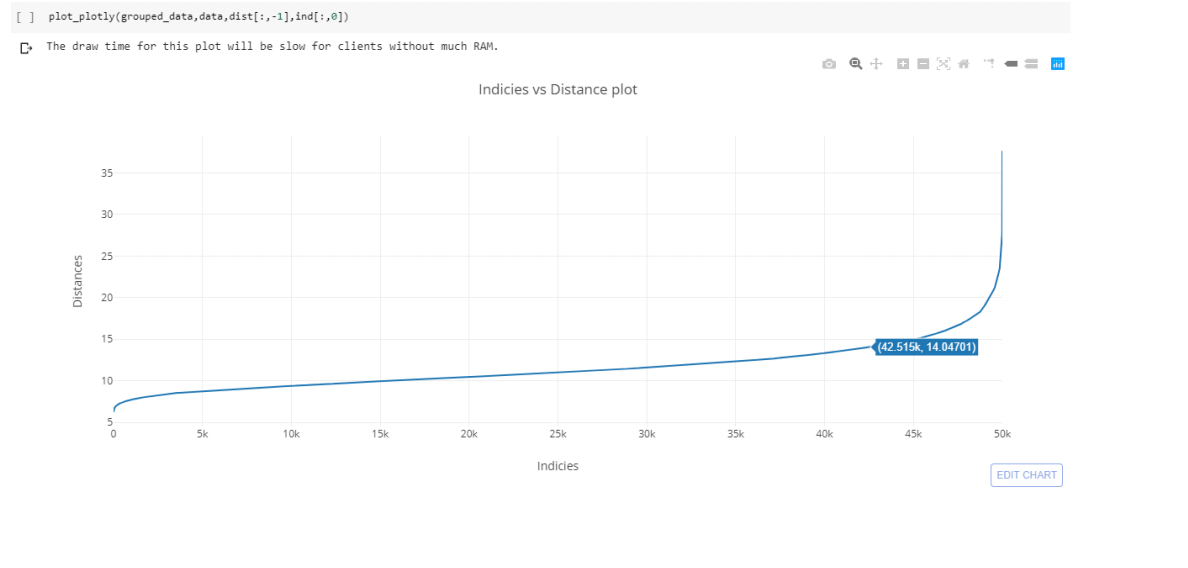

Observations: 

1)Plotly plot is plotted and it is observed that Eps value around 14 will be a suitable value.

2)Since the plot is not diplayed for some reason when the ipynb file is moved, I have attached an image of the interactive plot plotted using plotly.



For Eps = 13.0 the number of points in each cluster are:


 0    47463
-1    2534 
Name: labels, dtype: int64




==================== Plotting wordcloud and reviews for Eps = 13.0




Creating a dataframe with Reviews, Cleaned text and Clusters...
Dataframe is created!


The number of reviews in each cluster is:
 0    47463
-1    2534 
Name: Clusters, dtype: int64


**********************************************************************




**************************************** Cluster  -1 ****************************************


Plot of Word Cloud


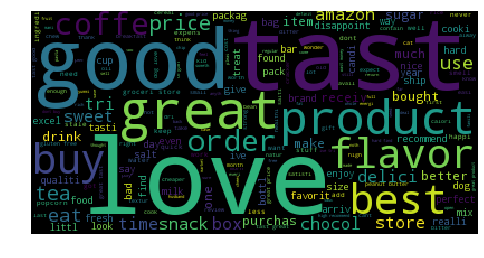





Printing 4 random reviews from cluster -1
-1    As I'm always looking for a DEAL on Cranaple by OS there is no DEAL here at $9.54 a bottle. When my local store has it around $3.58 a 64.oz bottle Thanks but No Thanks                                  
-1    Been using for about 4 months now with my 7 year old husky-shepard mix.  Seems to help her move a little better.                                                                                         
-1    These crackers are great.  Unfortunately, every box I've bought is about 50% broken.  And that's from several different stores.                                                                          
-1    These have the perfect consistency for caramel apples. They melt easily and harden perfectly. Some caramels are too soft and almost melt off the apples but these are great!                             
-1    This coffee is very weak.  I am very disappointed with this coffee.  Not worth the price.  i would not recommend thi

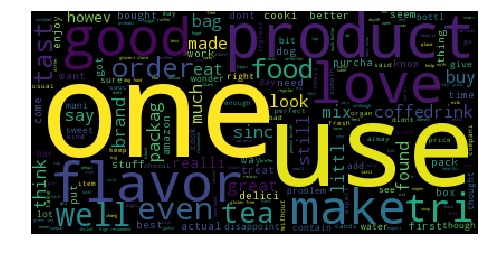





Printing 4 random reviews from cluster 0
0    Been drinkin gormet coffee many years now, bunch of different brands and roasters. It's hard to beat the Coffee Fool for quality and freshness, but I've come back to this Jerimias' pick for the quality and the savings I get here at Amazon. Its a great value and superb freshness--you'll be very pleased!                                            
0    Iopened the pkg and all but 25 waffle bowls survived. Iam left with an open house this weekend and not enough bowls!!!                                                                                                                                                                                                                                     
0    This stuff tastes amazing though and everyone I share with loves it! Although I am sure the seller did not mean to mislead buyers, each individual limoncho container is .4 oz and not 4 oz like written in the description.                        

In [0]:
dbscan(grouped_data,data,13.00,min_pts)

**Observations:**

**1.** When Eps = 13.00, the number of elements in cluster 0 are 47463 and points in cluster -1 (or noise points) are 2534.

**2.** Cluster -1 reviews seem to be about how the customers liked the product due to a frequent occurance of the words 'great', 'love', 'good', 'best'.

**3.** Cluster 0 reviews talked about how the customers used the product and how good the flavour was.

**4.** The number of points classified as noise increased with decrease in Eps value.



For Eps = 14.06 the number of points in each cluster are:


 0    48970
-1    1027 
Name: labels, dtype: int64




==================== Plotting wordcloud and reviews for Eps = 14.06




Creating a dataframe with Reviews, Cleaned text and Clusters...
Dataframe is created!


The number of reviews in each cluster is:
 0    48970
-1    1027 
Name: Clusters, dtype: int64


**********************************************************************




**************************************** Cluster  -1 ****************************************


Plot of Word Cloud


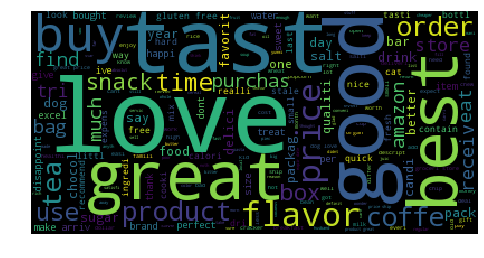





Printing 4 random reviews from cluster -1
-1    my dogs tell me that they are very good and good for their health..                                                                                                                                                               
-1    I purchased this coffee on 11/4, and as 12/14 I have not received the product.  I would not recommend this seller.                                                                                                                
-1    I have been trying to get hoodys peanut crunch and cashews for over a year now.  how do you buy them?                                                                                                                             
-1    The ingredient list for this item lists cocoa butter but the actual item contains ZERO cocoa butter, in fact the ingredient list on this listing is completely different from the package.  This is not white chocolate, avoid!!!!
-1    My cat loves the

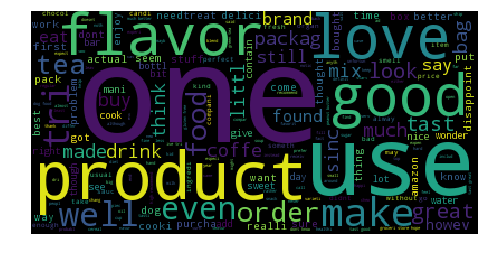





Printing 4 random reviews from cluster 0
0    Same exact product is available at Sams Club for $8.77. Wow! My Prime Membership is really paying off on this product...                                                                                                                                                                                                                                                                                                                                                                                                                                        
0    Purchasing Lundberg Jubilee, Gourmet Blend of Whole Grain Brown Rice, 16-Ounce Units (Pack of 6) was a great decision. This rice has a great nutty taste. The other benefit is that since it is whole grain it has a low glycemic index. The price is much better than I receive at the local grocers, when I can find this rice.<br />I love it and I highly recommend it. You may never go back to white rice!

In [0]:
dbscan(grouped_data,data,14.06,min_pts)

**Observations:**

**1.** When Eps = 14.06, the number of elements in cluster 0 are 48970 and points in cluster -1 (or noise points) are 1027.

**2.** Cluster -1 reviews seem to be about how the customers liked the product due to a frequent occurance of the words 'great', 'love', 'good', 'best'.

**3.** Cluster 0 reviews talked about how the customers used the product and how good the flavour was.



For Eps = 15.0 the number of points in each cluster are:


 0    49556
-1    441  
Name: labels, dtype: int64




==================== Plotting wordcloud and reviews for Eps = 15.0




Creating a dataframe with Reviews, Cleaned text and Clusters...
Dataframe is created!


The number of reviews in each cluster is:
 0    49556
-1    441  
Name: Clusters, dtype: int64


**********************************************************************




**************************************** Cluster  -1 ****************************************


Plot of Word Cloud


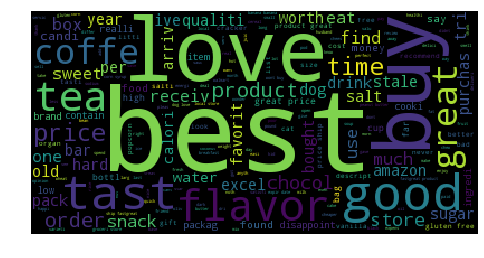





Printing 4 random reviews from cluster -1
-1    rated as low sodium and very much true.  Very high calorie with no flavor.  I will snack on them for a low carb diet but add salt and pepper
-1    a little dry...way too much chocolate coating.  I had to slice it off the sides                                                             
-1    what to say?<br />they arrived and the dogs loved them and all is well.                                                                     
-1    Quality of product is excellent, cost is excellent and delivery is superb.  Very satisfied.                                                 
-1    so so.there was great reviews on product only made it once will try it again                                                                
Name: Reviews, dtype: object








**************************************** Cluster  0 ****************************************


Plot of Word Cloud


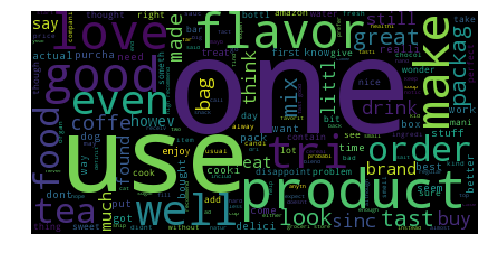





Printing 4 random reviews from cluster 0
0    When you taste these you only get the taste of salt. Either the package I got came from the batch Amazon had in storage for long period of time or when they packaged these someone overdozed the salt. I have these only because  the Roland Kalamata Pitted (whole) olives have been out of stock for couple month. As result had to dispose to trash Rolan Kalamata Halves.                                                                                                                                                                                                                                                                                                                                                  
0    As a chocolate lover, I enthusiastically looked forward to trying the new Fiber One brownies. Unfortunately, I was quite disappointed.  The texture is not quite up to that of a real brownie, lacking that treat's trademark chewiness and mois

In [0]:
dbscan(grouped_data,data,15.00,min_pts)

**Observations:**

**1.** When Eps = 15.00, the number of elements in cluster 0 are 49556 and points in cluster -1 (or noise points) are 441.

**2.** Cluster -1 reviews seem to be about how the customers liked the product due to a frequent occurance of the words 'great', 'love', 'good', 'best'.

**3.** Cluster 0 reviews talked about how the customers used the product and how good the flavour was.

**4.** The number of points classified as noise decreased with increase in Eps value.

# TFIDF WordVec

In [0]:
import pandas as pd
final = pd.read_csv("drive/grouped_data_200.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(30000) #Gets 30000 reviews of positive and 20000 negative scores
neg_2000 = neg.sample(20000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data.drop(['Unnamed: 0', 'Unnamed: 0.1','Score'], axis=1, inplace=True)
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (49999, 11)


In [0]:
list_of_sent=[]
for sent in grouped_data['CleanedText'].values: #Splits sentences into words and stores it in a list
    list_of_sent.append(sent.split())
print(grouped_data['CleanedText'].values[9])
print("*****************************************************************")
print(list_of_sent[9])

sauc hot sake hot get heat flavor one sauc sauc kick sill lot wonder flavor great kind meat use beef chicken pork like scrambl egg despit flavor lower sugar sodium mani sauc less guilti guilti pleasur watch diet cant wrong sauc
*****************************************************************
['sauc', 'hot', 'sake', 'hot', 'get', 'heat', 'flavor', 'one', 'sauc', 'sauc', 'kick', 'sill', 'lot', 'wonder', 'flavor', 'great', 'kind', 'meat', 'use', 'beef', 'chicken', 'pork', 'like', 'scrambl', 'egg', 'despit', 'flavor', 'lower', 'sugar', 'sodium', 'mani', 'sauc', 'less', 'guilti', 'guilti', 'pleasur', 'watch', 'diet', 'cant', 'wrong', 'sauc']


Observations: Get a list of all the words in data.

In [0]:
w2v_train=Word2Vec(list_of_sent,min_count=5,size=200, workers=4) #Initialises the Word2Vec model with words occuring more than 5 times.

w2v_train_words = list(w2v_train.wv.vocab) #This gives a dictionary of words which tells about the uniqueness of a word among other things.
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[298:315])

number of words that occured minimum 5 times  9549
sample words  ['krave', 'crunchi', 'outsid', 'middl', 'pleas', 'also', 'white', 'togeth', 'hope', 'stay', 'around', 'yumm', 'recov', 'addict', 'suggest', 'replac', 'real']


Observations:
Word2Vec model is built. We can see the number of times a word occured minimum 5 times.

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab_tf_idf = tf_idf_vect.fit_transform(grouped_data['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names()
dictionary = dict(zip(tfidf_feat, list(tf_idf_vect.idf_)))

Observations: Train the TFIDF vectorizations.

In [0]:
sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
sent_list = []
for sent in grouped_data['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # for each review/sentence 
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_train_words:
            try:
                vec = w2v_train.wv[word] # obtain the tf_idfidf of a word in a sentence/review
                tf_idf  = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors.append(sent_vec)
    row += 1
print(len(sent_vectors))
print(len(sent_vectors[0]))

49999
200


Observations: Gets the sentence vectors for data.

In [0]:
data = StandardScaler(with_mean=False).fit_transform(sent_vectors)

Observations: Standardize the data.

In [0]:
min_pts = len(data[0])*2 #Min_pts is taken as 2*d where d is dimensionality
neib = NearestNeighbors(n_neighbors=min_pts).fit(data) #Perform nearest neighbors on the standardized data
dist, ind = neib.kneighbors() #Get distance and indices matrix
dist[:,-1].sort() #Sort the last column of the distance matrix
ind[:,0].sort() #Sort the first column of the indices matrix

Observations: Get the min point value and nearest neighbours distances by taking min points as n_neighbors. Obtain distance and indices matrix.

In [0]:
plot_plotly(grouped_data,data,dist[:,-1],ind[:,0])

The draw time for this plot will be slow for clients without much RAM.


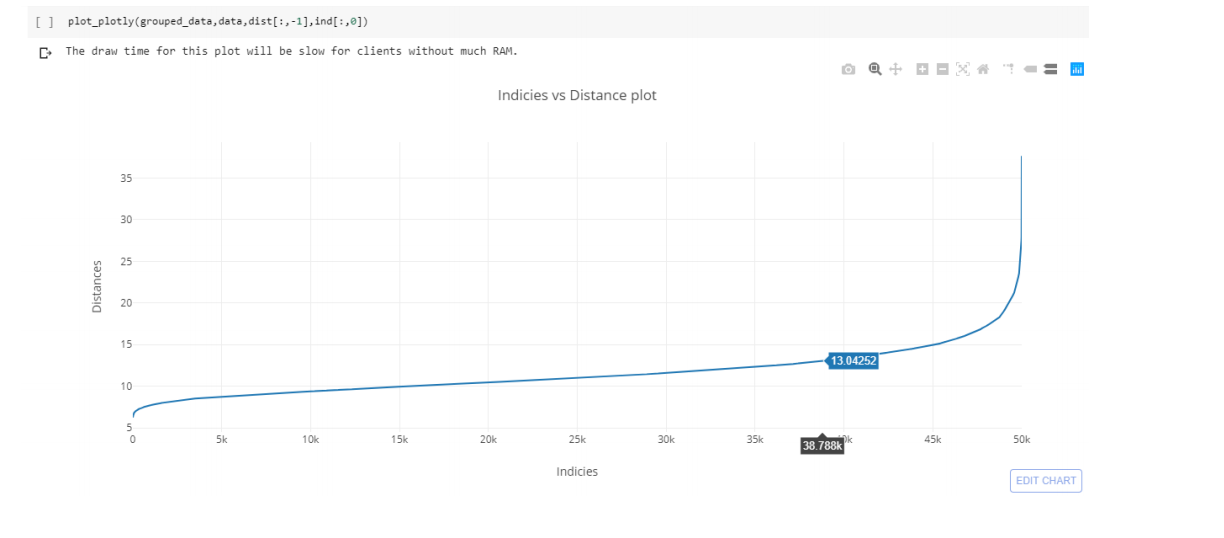

Observations: 

1) Plotly plot is plotted and it is observed that Eps value around 13 will be a suitable value.

2) Since the plot is not displayed when the ipynb file is moved for some reason, I have attached an image of the interactive graph plotted using plotly.



For Eps = 12.05 the number of points in each cluster are:


 0    48156
-1    1843 
Name: labels, dtype: int64




==================== Plotting wordcloud and reviews for Eps = 12.05




Creating a dataframe with Reviews, Cleaned text and Clusters...
Dataframe is created!


The number of reviews in each cluster is:
 0    48156
-1    1843 
Name: Clusters, dtype: int64


**********************************************************************




**************************************** Cluster  -1 ****************************************


Plot of Word Cloud


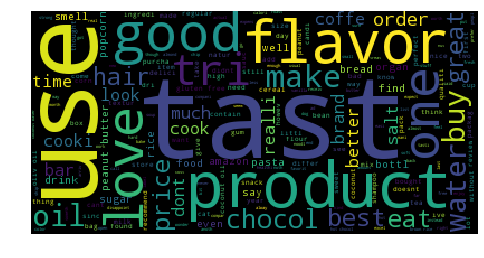





Printing 4 random reviews from cluster -1
-1    Works great. So much easier to use than the one you buy for the machine. Less mess - just throw it away!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

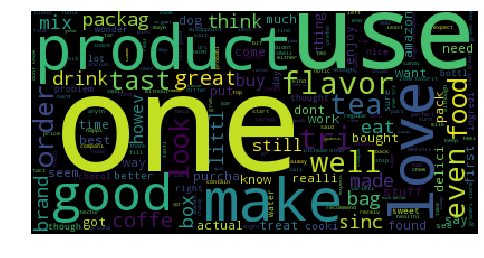





Printing 4 random reviews from cluster 0
0    H. Mitchell, I suspect you're joking about the granola providing you only 2 servings, but the back of the package suggests 3/4 cup per serving for a total of 6 servings.  I love the taste and texture of the ingredients, the delicate flavor, the gratification I get from knowing it will keep me satisfied until lunchtime.  Good job, whoever designed the granola.                                                                                                                                                                                                                                                                                                  
0    For those hazelnut lovers out there, you MUST TRY THIS!!!  I had no problems with the product as far as separation.  A good thorough mixing remedies this and I put some that was a little more solidified in the microwave for a few seconds to soften and then it mixed up just fine.<br /><br />I 

In [0]:
dbscan(grouped_data,data,12.05,min_pts)

**Observations:**

**1.** When Eps = 13.05, the number of elements in cluster 0 are 49206 and points in cluster -1 (or noise points) are 793.

**2.** Cluster -1 reviews seem to be about the taste and flavour of the products. Many reviews also mention products about chocolate and hair.

**3.** Cluster 0 reviews talked about how the customers used the product and how good the flavour was. They also talked about how they made use of them.

**4.** The number of points classified as noise increased with decrease in Eps value.



For Eps = 13.05 the number of points in each cluster are:


 0    49206
-1      793
Name: labels, dtype: int64




==================== Plotting wordcloud and reviews for Eps = 13.05




Creating a dataframe with Reviews, Cleaned text and Clusters...
Dataframe is created!


The number of reviews in each cluster is:
 0    49206
-1      793
Name: Clusters, dtype: int64


**********************************************************************




**************************************** Cluster  -1 ****************************************


Plot of Word Cloud


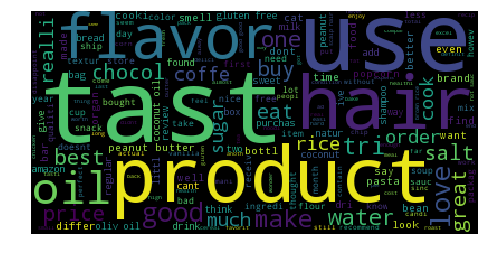





Printing 4 random reviews from cluster -1
-1    I love this gluten.  I've used other, more expensive gluten & this is just as good, if not better.<br /><br />I use it all the time in my baking.  I love it.  Connie                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

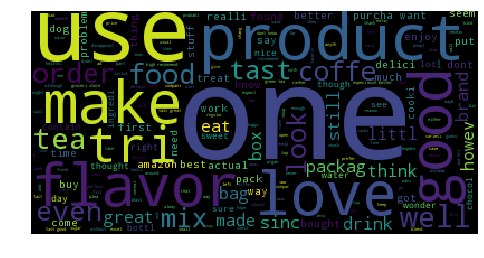





Printing 4 random reviews from cluster 0
0    I do not have a Senseo coffee pod maker.<br /><br />I use a 4cup small MR COFFEE pot and use<br />2 pods for 4 cups of coffee.  Works perfectly.<br /><br />I like the SUMATRA coffee a lot...bold, dark<br />and rich flavor.<br /><br />I add a little bit of BAILEYS IRISH CREAM to<br />each cup.<br /><br />I have tried the MELITTA coffee pods --  they<br />are weak and expensive... but,they do have<br />some very very interesting flavors.<br /><br />bette b prater<br />okc ok  62 retired                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [0]:
dbscan(grouped_data,data,13.05,min_pts)

**Observations:**

**1.** When Eps = 13.05, the number of elements in cluster 0 are 49206 and points in cluster -1 (or noise points) are 793.

**2.** Cluster -1 reviews seem to be about the taste and flavour of the products. Also a significant number of reviews mention that the product has something to do with the hair and oil.

**3.** Cluster 0 reviews talked about how the customers used the product and how good the flavour was. They also talked about how they made use of them.



For Eps = 14.05 the number of points in each cluster are:


 0    49677
-1    322  
Name: labels, dtype: int64




==================== Plotting wordcloud and reviews for Eps = 14.05




Creating a dataframe with Reviews, Cleaned text and Clusters...
Dataframe is created!


The number of reviews in each cluster is:
 0    49677
-1    322  
Name: Clusters, dtype: int64


**********************************************************************




**************************************** Cluster  -1 ****************************************


Plot of Word Cloud


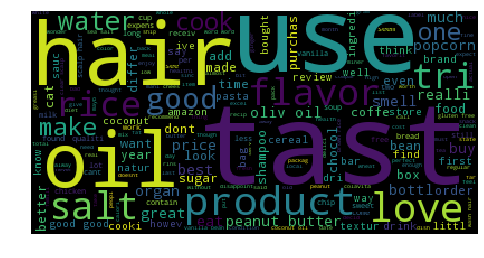





Printing 4 random reviews from cluster -1
-1    The coconut oil works great on my hair and skin. my hair responded great to the oil and it grew a little because of the oil.                         
-1    Bought 5LB of this cheese and I use it for mac and cheese. Very good cheese sauce I would definitely buy more!                                       
-1    Came as expected on expected time. Was what I was hoping for when comes for pacaging and taste. Very good!                                           
-1    this can chicken taste great in hot dishes, chicken salad, chicken helper, salads, or whatever calls for chicken well worth the money will buy again.
-1    Love this pancake mix.  This is the only brand we have used n years.                                                                                 
Name: Reviews, dtype: object








**************************************** Cluster  0 ****************************************


Plot of Word Cloud


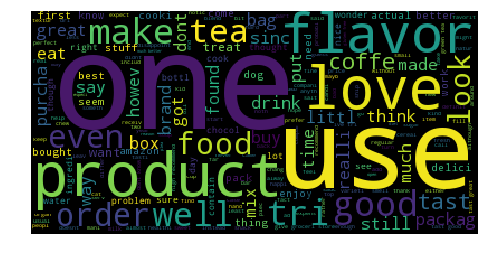





Printing 4 random reviews from cluster 0
0    These things are ridiculous.  To open a bag is to finish it.  I wish that they could be just, like, *medium* good, or even just "quite good" to "very good".  Unfortunately they're like the snack version of crack.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [0]:
dbscan(grouped_data,data,14.05,min_pts)

**Observations:**

**1.** When Eps = 14.05, the number of elements in cluster 0 are 49677 and points in cluster -1 (or noise points) are 322.

**2.** Cluster -1 reviews seem to be about hair products and oil products and how most customers used them. A significant number of reviews talked about taste and flavour of the products.

**3.** Cluster 0 reviews talked about how the customers used the product and how good the flavour was. They also talked about how they made use of them.

**4.** The number of points classified as noise decreased with increase in Eps value.

# Summary and Conclusions

1) Import the csv file containing pre processed data which is already arranged on the basis of time.

2) Three functions are created for plotting wordcloud, for plotting graph in plotly and performing DBSCAN.

3) The first function creates a dataframe with all the reviews, cleaned text and clusters. Then it prints the number of data points in each cluster. A wordcloud is then plotted along with a few random reviews from that cluster.

4) The second function plots graph between indices and distance array using plotly. Plotly is chosen so that we can pin point the exact coordinate for a point on the graph.

5) The third function performs DBSCAN and gets the best Eps value by plotting indices vs nearest distances. Then it gets the labels for visualisation through wordcloud.

6) These functions are applied on avg Word2Vec and TFIDF Word2Vec.

6) It can be observed that as the eps value increases, the number of points classified as a noise point decreases. Hence it is important to choose the right Eps value so that noise points are well seperated from other data points.